In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
import read_xml as read_xml

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tag import pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer
#initialized stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer=SnowballStemmer('english')
lemmatizer=WordNetLemmatizer()

from wordcloud import WordCloud, ImageColorGenerator

from gensim.utils import simple_preprocess
from gensim import corpora, models
import pyLDAvis.gensim

import pickle
import joblib

#download these if missing or if it's not up to date
#nltk.download('wordnet') 
#nltk.download('stopwords')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('vader_lexicon')

In [2]:
pd.options.mode.chained_assignment = None

## Table of Content
* [Problem Statement](#Problem-Statement)

* [Data Exploration](#Data-Exploration)
    * [Structure Base Table](#Structure-Base-Table)
    * [Additional Features](#Additional-Features)

* [Insights](#Insights)
    * [Overall Trend](#Overall-Trend)
    * [Topic Analysis](#Topic-Analysis)
    * [Sentiment Analysis](#Sentiment-Analysis)

## Problem Statement

You are approached by an artisan brewer client who is considering adding a new hoppy beer to their range - India pale ale (IPA). The client's marketing team would like to know **how consumers feel about this product and how the attitude toward IPA beer has changed over time**. They identified a question-answering website (stack exchange) as a source of genuine opinions. Use the XML datasets found in ./dataset/beer.stackexchange.com/ for this exercise. 

## Data Exploration
### Structure Base Table
[Back to top](#Table-of-Content)

In [3]:
df_comment=read_xml.read_xml('dataset/beer.stackexchange.com/Comments.xml')
df_comment.head()

,Id,PostId,Score,Text,CreationDate,UserId,ContentLicense,UserDisplayName
0,1,5,0,This is a matter of taste I guess.,2014-01-21T20:34:28.740,10,CC BY-SA 3.0,NaN
1,4,16,4,This question appears to be off-topic because ...,2014-01-21T20:52:14.490,39,CC BY-SA 3.0,NaN
2,5,16,8,"Obviously, you should pee into the empty beer ...",2014-01-21T20:55:44.723,41,CC BY-SA 3.0,NaN
3,6,5,3,Doesn't this depend on the type of beer as well?,2014-01-21T20:57:44.653,43,CC BY-SA 3.0,NaN
4,7,19,4,I retracted my close vote after reading this a...,2014-01-21T20:57:47.373,20,CC BY-SA 3.0,NaN


Column | Description
:---|:---
`Id` | Id of the comment
`PostId` | Id of the post the comment is posted to (could be answer or question)
`Score` | Number of upvotes (if any) that the comment received
`Text` | Comment body
`CreationDate` | Comment creation date
`UserId` | UserId (null if user is deleted)
`ContentLicense` | Content distribution license
`UserDisplayName` | User's display name

In [4]:
df_post=read_xml.read_xml('dataset/beer.stackexchange.com/Posts.xml')
df_post.head(3)

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditDate,...,Tags,AnswerCount,CommentCount,ContentLicense,ParentId,FavoriteCount,ClosedDate,LastEditorDisplayName,OwnerDisplayName,CommunityOwnedDate
0,1,1,4,2014-01-21T20:26:05.383,20,2346,<p>I was offered a beer the other day that was...,7,8,2014-01-21T22:04:34.977,...,<hops>,1,0,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,175,2014-01-21T20:27:29.797,24,3072,"<p>As far as we know, when did humans first br...",7,NaN,NaN,...,<history>,4,3,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,13,2014-01-21T20:30:17.437,21,517,<p>How is low/no alcohol beer made? I'm assumi...,7,NaN,NaN,...,<brewing>,3,0,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN,NaN


Column | Description
:---|:---
`Id` | Id of the post
`PostTypeId` | Id of the Post type (1 = Question; 2 = Answer; 3 = Orphaned tag wiki; 4 = Tag wiki excerpt; 5 = Tag wiki; 6 = Moderator nomination;7 = "Wiki placeholder" (seems to election related);8 = Privilege wiki
`AcceptedAnswerId` | Id of the accepted answer (only present if PostTypeId=1, i.e. a question)
`CreationDate` | Post creation date
`Score` | Number of upvotes the post received
`ViewCount` | Number of views from registered user
`Body` | Body of the post (rendered as HTML, not Markdown)
`OwnerUserId` | Owner of the thread, only present if user is not deleted (always -1 for tag wiki entries, i.e. the community user owns them)
`LastEditorUserId` | Id of the last editor
`LastEditDate` | Last edited date of the post
`LastActivityDate` | Last post activity date
`Title` | Title of the post (only available for questions)
`Tags` | Tags inserted in by the owner of the post (only available for questions)
`AnswerCount` | Number of answers to a question
`CommentCount` | Number of comments to a post
`ContentLicense` | Content distribution license
`ParentId` | Id of the question (only present if PostTypeId=2, i.e. an answer)
`FavoriteCount` | Number of times a question is bookmarked
`ClosedDate` | Date the post is closed
`LastEditorDisplayName` | Last editor's display name
`OwnerDisplayName` | Thread owner's display name
`CommunityOwnedDate` | Community set up date (only present if the post is a community wiki)

These two tables (Posts & Comments) offer a lot of information to uncover opinion and attitudes to IPA (or other types of beer), so we will use them to form a basis for our topic analysis and sentiment analysis. 

In general, people can ask beer type (e.g. IPA, stout, lager) specific questions, or just generic beer questions (e.g. temperature, history), and people might answer back with beer type specific answers or generic answers. So here, we will not differentiate the post types (be it questions, answers or even comments). We will gather the key columns from the Posts and Comments tables, and build a combined table.

In [5]:
#Make a smaller combined table
cols_to_keep_post=['Id','PostTypeId','AcceptedAnswerId','CreationDate','Score','ViewCount', 'Body','Title','Tags']
df_post_lite=df_post[cols_to_keep_post].copy()

cols_to_keep_comment=['Id','PostId','Score','Text','CreationDate']
df_comment_lite=df_comment[cols_to_keep_comment].copy()
df_comment_lite.columns=['Id','PostId','Score','Body','CreationDate']
df_comment_lite['Id']='C_'+ df_comment_lite['Id'] #Add a prefix to differentiate the ID
df_comment_lite['PostTypeId']='9' # 9 for comment

df=pd.concat([df_post_lite,df_comment_lite], axis=0, sort=False)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 0 to 3620
Data columns (total 10 columns):
Id                  7200 non-null object
PostTypeId          7200 non-null object
AcceptedAnswerId    636 non-null object
CreationDate        7200 non-null object
Score               7200 non-null object
ViewCount           1065 non-null object
Body                7200 non-null object
Title               1065 non-null object
Tags                1065 non-null object
PostId              3621 non-null object
dtypes: object(10)
memory usage: 618.8+ KB


The combined table will have 7200 rows (union from the two tables) and 10 columns.

### Additional Features
[Back to top](#Table-of-Content)

In [7]:
#Create a full verbatim of the text
df['Body'].fillna('', inplace=True)
df['Title'].fillna('', inplace=True)
df['Tags'].fillna('', inplace=True)
df['Verbatim']=df['Body']+' '+df['Title']+' '+df['Tags']
df['Verbatim']=df['Verbatim'].str.lower()

#Create keyword base indicator
df['IPA']=np.where(df['Verbatim'].str.contains(' ipa'), 1,
                   np.where(df['Verbatim'].str.contains('indian pale ale'), 1, 0))
df['Ale']=np.where((df['Verbatim'].str.contains('ale'))& (df['IPA']==0), 1, 0)
df['Lager']=np.where(df['Verbatim'].str.contains('lager'), 1, 0)
df['Pilsner']=np.where(df['Verbatim'].str.contains('pilsner'), 1, 0)
df['Stout']=np.where(df['Verbatim'].str.contains('stout'), 1, 0)
df['Wheat']=np.where(df['Verbatim'].str.contains('wheat'), 1, 0)
df['Belgium']=np.where(df['Verbatim'].str.contains('belgium'), 1, 0)

#Date and Month variable
df['CreationDate'] = pd.to_datetime(df['CreationDate'])
df['CreationMonth'] = df['CreationDate'].dt.to_period('M')

In [8]:
#Remove records with less than 30 character - as a rule of thumb
df=df[df['Verbatim'].map(len) >= 30]

## Insights
### Overall Trend
[Back to top](#Table-of-Content)

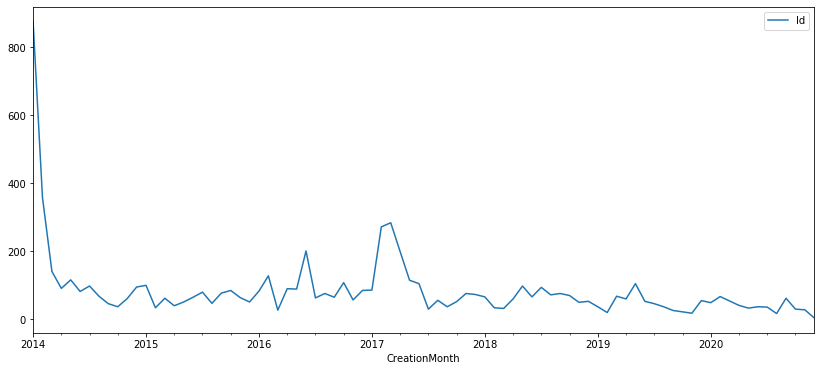

In [9]:
df_count=df[['CreationMonth','Id']].groupby('CreationMonth').count().reset_index()
df_count.plot(x='CreationMonth', figsize=(14,6));

Aside from the initial rush (probably due to the platform first launched) and a few spikes around 2016-2017, beer topic seems to have a relatively consistent trend. From 2014 to recent years, there have been fairly stable volume of posts (be it questions or answers). However, there does seem to be a slightly decreasing trend in this topic. It's possible that younger generations are not drinking as much or are not as passionate about beers as the older generation. It's also possible that internet users are just not using stack exchange as much as they used to.

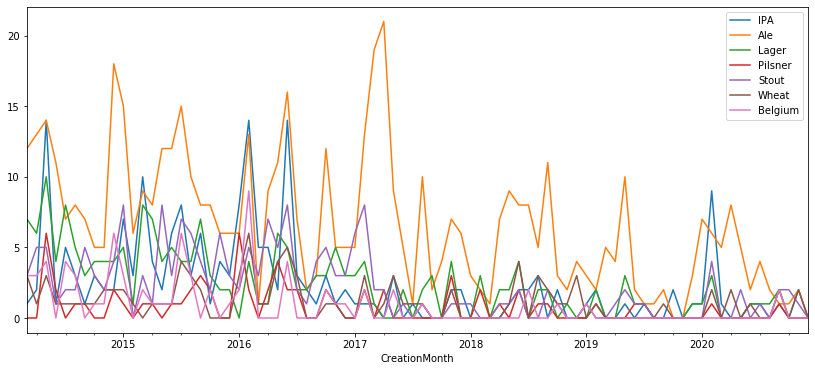

In [10]:
df_count_type=df[['CreationMonth', 'IPA', 'Ale', 'Lager', 'Pilsner', 'Stout', 'Wheat',
                  'Belgium']][df['CreationDate'] >= '2014-03-01'].groupby('CreationMonth').sum().reset_index()
df_count_type.plot(x='CreationMonth', figsize=(14,6));

At a rough glance, Ale seems to be the most regularly mentioned beer type, followed by IPA; after that, Lager is also a popular topic.

### Topic Analysis
[Back to top](#Table-of-Content)

Since our goal is to understand people's opinion about IPA, we will do a further deep dive into the relevant topics when it comes to IPA.

In [11]:
df_ipa=df[df['IPA']==1]

In [12]:
#show top frequency words
def freq_words(x, terms = 30): 
    
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
  
    fre_dist = nltk.FreqDist(all_words) 
    df_words = pd.DataFrame({'word':list(fre_dist.keys()), 'count':list(fre_dist.values())}) 
  
    # selecting top n most frequent words 
    d = df_words.nlargest(columns="count", n = terms) 
  
    # visualize words and frequencies
    plt.figure(figsize=(12,8)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

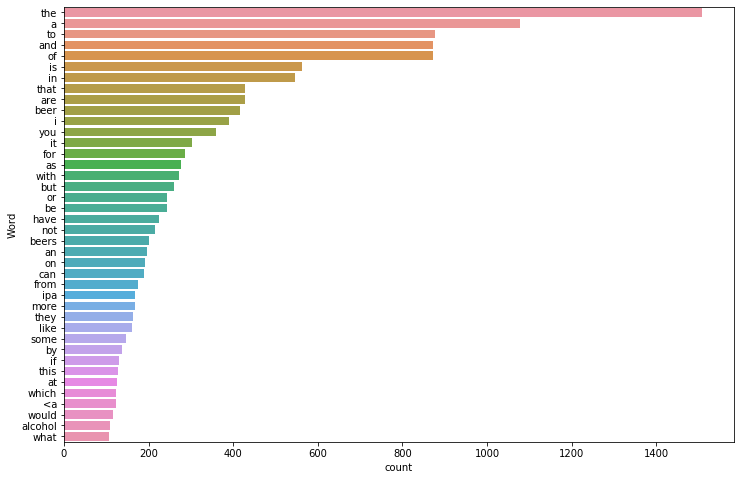

In [13]:
freq_words(df_ipa['Verbatim'], terms=40)

The most frequent words are mostly comprise stop words; but it's good to update the stop words list to cater to the specific context we are working on - IPA beer.

In [14]:
#add extra stop words seen
stop_words.update(['beer','beers','<a','ipa','rel="nofollow"','one','ipas','would','also','even','may'])
#also added ones seen after the cleansing

In [15]:
#function to find the part-of-speech tag
def find_pos(token_list):
    for word, tag in pos_tag(token_list):
        if tag.startswith('N'):
            pos = 'n'
        elif tag.startswith('V'):
            pos = 'v'
        elif tag.startswith('R'):
            pos = 'r'
        else:
            pos = 'a'
    return pos

In [16]:
#one stop shop function to clean up the text
def clean_text(text):
    
    cleanText=text
    
    # clean html links on the body
    html = re.compile('<[^>]*>') # remove everything inside the html tags
   
    cleanText = re.sub(html, ' ', str(cleanText))
    
    # remove stopwords and lemmatize nouns
    tokens = simple_preprocess(cleanText) 
    # remove new line, lowercase, keep alphabet, remove punctuation and special characters 
    #- all taken care by gensim's simple preprocess
    
            
    cleanTokens = [lemmatizer.lemmatize(token, 
                                        pos=find_pos([token])) for token in tokens if not token in stop_words and len(token) > 2]
    cleanText = ' '.join(cleanTokens)

    return cleanText

In [17]:
df_ipa['CleanVerbatim'] = df_ipa['Verbatim'].apply(lambda x: clean_text(x))

In [18]:
#freq_words(df_ipa['CleanVerbatim'], terms=40) #- use this to add to the stop word list and clean again

With the cleaned up verbatim, we can start generating a word cloud.

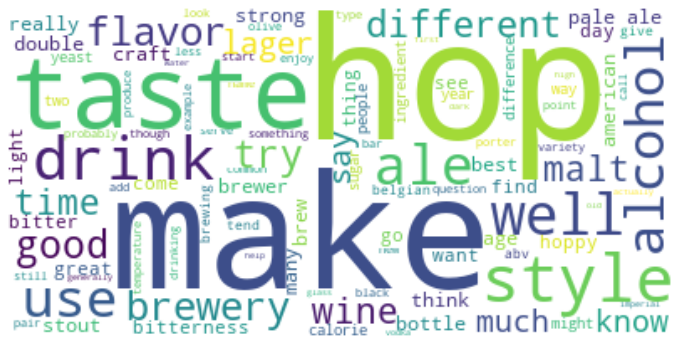

In [19]:
cloud_text = " ".join(doc for doc in df_ipa['CleanVerbatim'])
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white", max_words=100).generate(cloud_text)

# Display the generated image:
plt.figure(figsize=(12,8)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

Based on this word cloud, we can infer, when IPA is mentioned, it's likely people are talking about:
   * IPA being one of the many **different** beer **styles**
   * IPA's characteristics of lower **alcohol** content and strong **hoppy flavour**, and how it affects **taste**
   * IPA's unique **making** or **brewing** process
   * IPA in comparison to **wine**, **ale**, **pale ale** and other types of **craft** beers
   
Aside from word cloud, we can also try using Latent Dirichlet Allocation (LDA) for topic modelling.

In [20]:
def tokenize(list):
    lda_tokens=[]
    for i in list:
        tokens=i.split()
        #for token in tokens:
        lda_tokens.append(tokens)
            
    return lda_tokens

In [21]:
#build dictionary
token_ipa=tokenize(df_ipa['CleanVerbatim'])
dictionary_ipa = corpora.Dictionary(token_ipa)
corpus_ipa = [dictionary_ipa.doc2bow(text) for text in token_ipa]
pickle.dump(corpus_ipa, open('corpus_ipa.pkl', 'wb')) #write binary
dictionary_ipa.save('dictionary_ipa.gensim')

In [22]:
#apply gemsim LDA models
ldamodel_ipa = models.ldamodel.LdaModel(corpus_ipa, num_topics = 6, id2word=dictionary_ipa, passes=15)
ldamodel_ipa.save('model_ipa.gensim')
topics = ldamodel_ipa.print_topics(num_words=6)
for topic in topics:
    print(topic)

(0, '0.012*"olive" + 0.011*"hop" + 0.010*"lager" + 0.010*"style" + 0.010*"taste" + 0.009*"ale"')
(1, '0.011*"ale" + 0.010*"hop" + 0.009*"like" + 0.008*"abv" + 0.008*"wine" + 0.008*"make"')
(2, '0.013*"ale" + 0.012*"style" + 0.011*"like" + 0.009*"double" + 0.008*"taste" + 0.008*"get"')
(3, '0.032*"day" + 0.028*"national" + 0.008*"alcohol" + 0.007*"hop" + 0.007*"craft" + 0.006*"brewery"')
(4, '0.019*"drink" + 0.017*"alcohol" + 0.017*"calorie" + 0.010*"say" + 0.008*"wine" + 0.007*"well"')
(5, '0.015*"style" + 0.012*"hop" + 0.011*"like" + 0.010*"flavor" + 0.009*"bottle" + 0.008*"brewery"')


In [23]:
# dictionary_ipa = corpora.Dictionary.load('dictionary_ipa.gensim')
# corpus_ipa = pickle.load(open('corpus_ipa.pkl', 'rb'))
# ldamodel_ipa = models.ldamodel.LdaModel.load('model_ipa.gensim')

lda_display = pyLDAvis.gensim.prepare(ldamodel_ipa, corpus_ipa, dictionary_ipa, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/rliao/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Inferring from the keywords and the relative positions of the topics, we can gather:

   * **Topic 2** seems to be the most prominent, which seems to be about the brewing method  using hop and malt
   * **Topic 1** is the next biggest topic, which seems to be around different styles of beer and how IPA's hoppiness gives a very different taste
   * **Topic 4** is a topic that is very different from the rest; it seems about IPA's alcohol content (ABV) - it's of course tied to calorie
   * **Topic 3** is another different topic far from the rest, which could be about the best IPA age (how long to ferment, and how soon you should drink it after it's bottled 

### Sentiment Analysis
[Back to top](#Table-of-Content)

To understand the sentiment of the IPA related posts and comments, we will use the pre-trained `Sentiment Intensity Analyzer` from NLTK.

In [24]:
#initiate pre-trained
sia = SentimentIntensityAnalyzer()

In [25]:
#function to extract compound score - sum of positive, negative, neutral score and normalize to be between -1 and 1
def get_compound_score(text):
    
    result=sia.polarity_scores(text)
    compound=result.get('compound')
    return compound

In [26]:
df_ipa['SentimentScore'] = df_ipa['CleanVerbatim'].apply(lambda x: get_compound_score(x))

In [27]:
df_ipa['Score_1']=df_ipa['Score'].astype(int)+1 #add one to avoid multiplying zero
df_ipa['SentimentScore_weighted']=df_ipa['SentimentScore']*(df_ipa['Score_1'])

We will create a weighted sentiment score taking into account the number **up** votes and **down** votes the posts received. Naturally, if the post has a positive sentiment, but the general public is down voting it, it could suggest that the overall sentiment is negative, and vice versa.

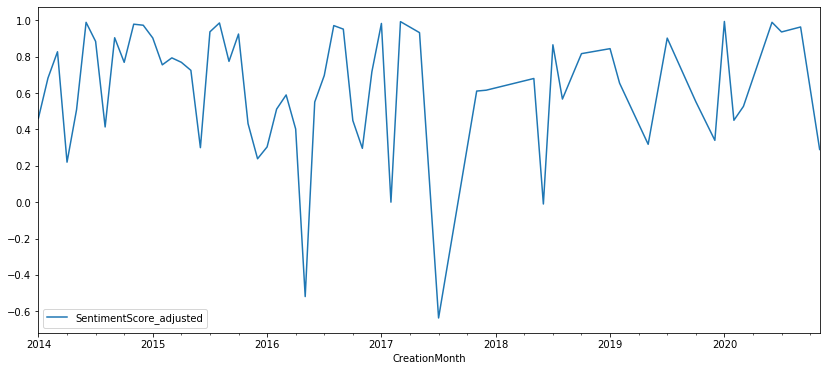

In [28]:
df_ipa_sentiment=df_ipa[['CreationMonth','SentimentScore_weighted', 'Score_1']].groupby('CreationMonth').sum().reset_index()
df_ipa_sentiment['SentimentScore_adjusted']=df_ipa_sentiment['SentimentScore_weighted']/df_ipa_sentiment['Score_1']
df_ipa_sentiment.plot(x='CreationMonth',y='SentimentScore_adjusted', figsize=(14,6));

It seems the sentiment towards IPA has been overall positive, with only May 2016 and July 2017 dipping into the negative. It's possible that these two months only have a few posts and thus one negative one might drag the whole month down. Further investigation into the data reveals that:

**May-2016:**
   * Two posts were made this month, one is about mixing beer with other alcohol or non alcoholic drink to create a beer cocktail - overall neutral. The other post was a complaint on the IBU (International Bitterness Units) measuring system, which received quite a few up-votes. The general consensus is that there are a lot IPAs that are rated in the 40s or 50s for IBU, but in practice they are much more bitter than stouts in the 80+ range. The rating seems to not be aligned with the hoppiness and the actual taste of the beer.

**July-2017:**
   * Only 1 comment is added this month mentioning IPA; it's about mixing vodka with beer, the comment was "Put some low quality vodka in my triple IPA and I was not disappointed", which suggest it's misclassified negative sentiment 